In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
from src.loader import slack_parser
from src.loader import all_messages
from src.loader import test
import src.utils as utils

LOADING THE DATA IN THE ANONYMIZED FOLDER

In [4]:

data = SlackDataLoader("../anonymized")


MESSAGES


In [5]:
# messages in a the document
print(data.path)
messages_dff = slack_parser(data.path +"/week-2-group-8")
#messages.describe()
#all_messages()
messages = all_messages()
messages.describe()
messages.head()
#test = all_messages()


../anonymized
slack_parser called with argument: ../anonymized/week-2-group-8 
all messages called
slack_parser called with argument: ../anonymized/ab_test-group 
slack_parser called with argument: ../anonymized/all-de-week12 
slack_parser called with argument: ../anonymized/all-career-exercises 
slack_parser called with argument: ../anonymized/all-community-building 
slack_parser called with argument: ../anonymized/all-ideas 
slack_parser called with argument: ../anonymized/all-ml-week12 
slack_parser called with argument: ../anonymized/all-resources 
slack_parser called with argument: ../anonymized/all-technical-support 
slack_parser called with argument: ../anonymized/all-web3-week12 
slack_parser called with argument: ../anonymized/all-week1 
slack_parser called with argument: ../anonymized/all-week2 
slack_parser called with argument: ../anonymized/all-week3 
slack_parser called with argument: ../anonymized/all-week4 
slack_parser called with argument: ../anonymized/all-week5 
sla

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,"Hi guys,\nI thought having a group chat would ...",Anita Rodriguez,1661766066.863109,text,0,0,0,0,0,ab_test-group
1,message,good!!,Michael Gonzalez,1661766159.852649,text,0,0,0,0,0,ab_test-group
2,message,Thanks <@U03U9FWPNCE>,Robert Carter,1661766226.215889,text,0,0,0,0,0,ab_test-group
3,message,Nice <@U03U9FWPNCE>,Phillip Atkins,1661766241.597379,text,0,0,0,0,0,ab_test-group
4,message,I have been missing deadlines and I am trying ...,Anita Rodriguez,1661766295.939119,text,0,0,0,0,0,ab_test-group


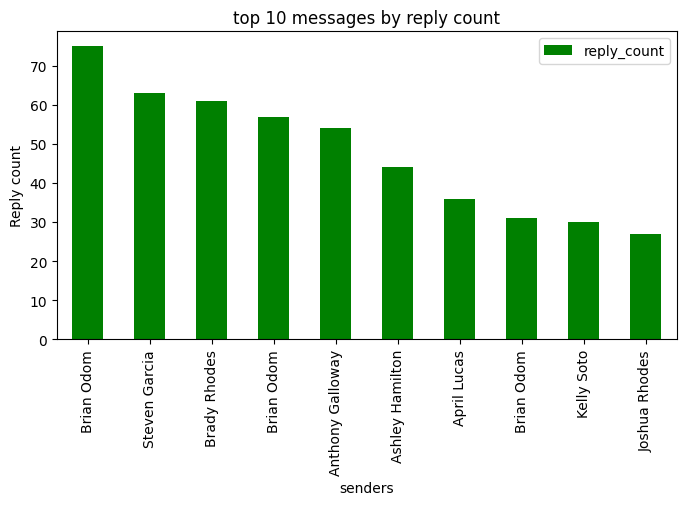

"\nimport matplotlib.pyplot as plt\n\nreply_counts = test.sort_values(by='reply_count', ascending=False)\ntop_10 = reply_counts.head(10)\n\ntop_10.plot(kind='bar', x='post_title', y='reply_count', figsize=(8, 4), color='green')\nplt.xlabel('Post Title')\nplt.ylabel('Reply Count')\nplt.title('Top 10 Posts by Reply Count')\nplt.show()\n\nfirst_few_rows = reply_counts.head()\nprint(first_few_rows)"

In [6]:
#My messages reply counts

reply_counts = messages.sort_values(by=['reply_count'],ascending=False)
top_10 = reply_counts.head(10)
top_10.plot(kind='bar', x ='sender_name', y= 'reply_count',figsize=(8,4), color='green')
plt.xlabel("senders")
plt.ylabel("Reply count")
plt.title("top 10 messages by reply count")
plt.show()

'''
import matplotlib.pyplot as plt

reply_counts = test.sort_values(by='reply_count', ascending=False)
top_10 = reply_counts.head(10)

top_10.plot(kind='bar', x='post_title', y='reply_count', figsize=(8, 4), color='green')
plt.xlabel('Post Title')
plt.ylabel('Reply Count')
plt.title('Top 10 Posts by Reply Count')
plt.show()

first_few_rows = reply_counts.head()
print(first_few_rows)'''


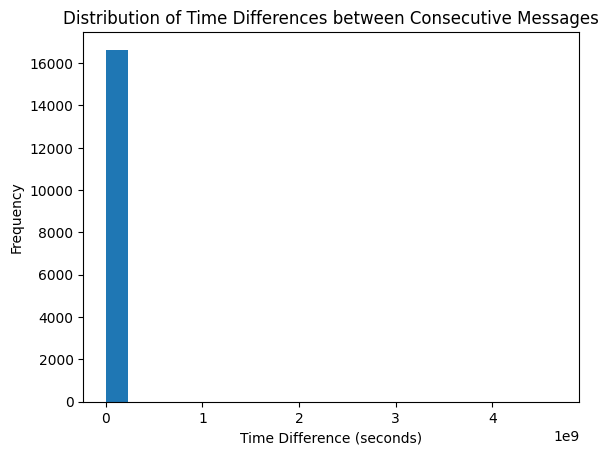

In [7]:
# plotting a histogram of time differences between consecutive messages


sorted_messages = messages.sort_values('msg_sent_time')
sorted_messages['msg_sent_time'] = pd.to_datetime(sorted_messages['msg_sent_time'], unit='s')
time_difference = sorted_messages['msg_sent_time'].diff().dt.total_seconds()*1000
plt.hist(time_difference.dropna(), bins=20)
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences between Consecutive Messages')
plt.show()

USERS

In [8]:
#get users

user = data.get_users()
df = pd.DataFrame(user)
print(type(user))
df.describe()



<class 'list'>


,tz_offset,updated
count,57.000000,7.100000e+01
mean,3410.526316,1.672156e+09
std,12987.489643,1.243181e+07
min,-28800.000000,1.660570e+09
25%,3600.000000,1.663371e+09
50%,10800.000000,1.667401e+09
75%,10800.000000,1.676618e+09
max,10800.000000,1.700820e+09


CHANNELS

In [9]:
# a channel
channels = data.get_channels()
df = pd.DataFrame(channels)
#df.head(20)


### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [10]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()



In [11]:
'''import os, sys
import re
import json
import glob
import datetime
from collections import Counter

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory (one level up)
parent_dir = os.path.dirname(current_dir)

# Construct the path to the 'network-analysis' directory
network_analysis_path = os.path.join(parent_dir, 'network-analysis')

# Append the path to sys.path
sys.path.append(network_analysis_path)


import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

from src.loader import *
from src.utils import *
from src.config import *

loaded_data = SlackDataLoader("anonymized")'''

usage: ipykernel_launcher.py [-h] [--output OUTPUT] --path PATH
                             [--channel CHANNEL] [--userfile USERFILE]
ipykernel_launcher.py: error: the following arguments are required: --path


SystemExit: 2

d:\10academy\week 0\network-analysis\venv3\lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [ ]:
# which user has the highest number of reply counts?

In [ ]:
# Visualize reply counts per user per channel

In [ ]:
# what is the time range of the day that most messages are sent?


In [ ]:
# what kind of messages are replied faster than others?

In [ ]:
# Relationship between # of messages and # of reactions

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Which users got the most reactions?

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?